In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns
import random

In [2]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [3]:
pd.set_option('display.max_rows', 500)

In [4]:
conn = psycopg2.connect(database="postgres",
                        host="pklmartdb.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="momentum101",
                        port="5432")
conn.autocommit = True

In [5]:
"""
def pullawsdata(tablename):
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT column_name FROM information_schema.columns where table_name='{tablename}';")
            cols=cursor.fetchall()
            print(cols)
            cols = [cols[x][0] for x in range(len(cols))]
            print(cols)
            cols = set(cols).symmetric_difference(["create_dtm","maint_dtm","dt_played"])
            print(cols)
            cursor.execute(f"DROP TABLE IF EXISTS cmmtemp; CREATE TEMP TABLE cmmtemp AS SELECT * FROM pklm_prd.{tablename}; ALTER TABLE cmmtemp DROP COLUMN IF EXISTS create_dtm,DROP COLUMN IF EXISTS maint_dtm,DROP COLUMN IF EXISTS dt_played;SELECT * FROM cmmtemp;")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=list(cols)))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)
"""

'\ndef pullawsdata(tablename):\n    with conn,conn.cursor() as cursor:\n        try:\n            cursor.execute(f"SELECT column_name FROM information_schema.columns where table_name=\'{tablename}\';")\n            cols=cursor.fetchall()\n            print(cols)\n            cols = [cols[x][0] for x in range(len(cols))]\n            print(cols)\n            cols = set(cols).symmetric_difference(["create_dtm","maint_dtm","dt_played"])\n            print(cols)\n            cursor.execute(f"DROP TABLE IF EXISTS cmmtemp; CREATE TEMP TABLE cmmtemp AS SELECT * FROM pklm_prd.{tablename}; ALTER TABLE cmmtemp DROP COLUMN IF EXISTS create_dtm,DROP COLUMN IF EXISTS maint_dtm,DROP COLUMN IF EXISTS dt_played;SELECT * FROM cmmtemp;")\n            data=cursor.fetchall()\n            return(pd.DataFrame(data,columns=list(cols)))\n        except Exception as inst:\n            print(type(inst))    \n            print(inst.args)     \n            print(inst)\n'

In [6]:
def pullawsdata(tablename):
    pdict = {"rally":{"query":"SELECT game_id, rally_id, rally_nbr, srv_team_id, w_team_id, to_team_id FROM pklm_prd.rally;", \
             "cols":['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']}, \
    "team":{"query":"SELECT team_id,team_nm FROM pklm_prd.team;", \
             "cols": ['team_id','team_nm']}, \
    "game":{"query":"SELECT match_id,game_id,game_nbr,score_w,score_l,w_team_id,l_team_id,skill_lvl FROM pklm_prd.game;", \
             "cols":['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']}}
    qry = pdict[tablename]["query"]
    cls = pdict[tablename]["cols"]
    
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(qry)
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=cls))
        except Exception as inst:
            print(f"inst \t type: {type(inst)} \t args: {inst.args}\n")

In [7]:
def generate_streak_info(df,strkcol):
    """
    Parameters
    ----------
    df: A chronologically pre-sorted homogenous dataframe,\
    strkcol: Column within df with 2 unique values    
    Returns
    -------
    streaks: df with a new column strk_{strkcol} with running streak sum
    """
    data = df[strkcol].to_frame()
    data['strk_init'] = data[strkcol].ne(data[strkcol].shift())
    data['strk_id'] = data.strk_init.cumsum()
    strk_field = f'strk_{strkcol}'
    data[strk_field] = data.groupby('strk_id').cumcount() + 1
    streaks = pd.concat([df, data[strk_field]], axis=1)
    streaks[strk_field] = streaks[strk_field].astype(int)
    return streaks

In [8]:
def streakdist(l):
    """
    Parameters
    -----------
    l:nested list of nested lists of streak lists
    Returns
    -------
    dist:list of tuples (x,y) where x is streak length and y is frequency
    """
    return list(Counter(sorted(sum([x[1]*[x[0]] for x in sum(l,[])],[]))).items())

In [9]:
def streakpct(d):
    """
    Parameters
    -----------
    d:list of tuples (x,y) where x is streak length and y is frequency
    Returns
    -------
    pcts:list of tuples (x,y) where x is streak length and y is percentage
    """    
    num = sum([x[1] for x in d])
    pcts = [(x[0],round(100*(x[1]/num),2)) for x in d]
    return pcts

In [40]:
def streakcounter(skill='All'):
    #pull game data
    game=pullawsdata('game')[['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']]
    game['game_id'] = [int(x[1:]) for x in game.game_id]
    game['match_id'] = [int(x[1:]) for x in game.match_id]
    game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
    game = game.sort_values(['match_id','game_id']).reset_index(drop=True)
    
    #pull rally data
    rally=pullawsdata('rally')
    rally = rally[['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']]
    rally['game_id'] = [int(x[1:]) for x in rally.game_id]
    rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
    rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)
    
    #create column 'srv_win' capturing the rally winner if serving
    sloc = rally.index[rally.srv_team_id == rally.w_team_id]
    rally['srv_win'] = rally.srv_team_id.iloc[sloc]

    #filter to skill level
    print(f'Counting streak lengths pre/post timeout for skill level: {str.upper(skill)}\n')
    if skill in ['2.5','3.0','3.5','4','4.0','4.5','5.0','5']:
        skill_games = game.game_id[game.skill_lvl == str(float(skill))]
        rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(skill_games).groupby(level=0).any())]
    elif skill == 'Pro':
        skill_games = game.game_id[game.skill_lvl == 'Pro']
        rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(skill_games).groupby(level=0).any())]
    elif skill == 'Amateur':
        skill_games = game.game_id[game.skill_lvl != 'Pro']
        rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(skill_games).groupby(level=0).any())]
    else:
        skill_games = game.game_id
        rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(skill_games).groupby(level=0).any())]        
    
    print(f'# skill games:{len(skill_games)}\n')
    #remove games without timeouts
    to_games=[]
    for i in skill_games:
        igame = rally[rally.game_id==i]
        todict[0].append(1.0)
        if len(igame[igame.to_team_id != 'N/A']) > 0:
            to_games.append(i)
    rally = rally[list(pd.DataFrame(rally['game_id']).stack().isin(to_games).groupby(level=0).any())]
    print(f'# games with timeouts: {len(to_games)}')
    
    
    #generate streaks of timeout taking team's opponent winning as server
    srv_win_strks=[]
    for i in game.game_id:
        print(f'\ngame_id: {i}\n')
        dfi = rally[rally.game_id==i]
        dfi = generate_streak_info(dfi,'srv_win')
        srv_win_strks.append(list(dfi.strk_srv_win))
    srv_win_strks = list(np.concatenate(srv_win_strks).flat)
    srv_win_strks = [int(x) for x in srv_win_strks]
    rally['srv_win_strks'] = srv_win_strks
    rally.srv_win_strks.iloc[rally.srv_win.isnull()] = 0
    #must set srv_win to srv_team_id after streak lengths are generated, allowing filtering to streak 0s (server loses)
    rally.srv_win = rally.srv_team_id
    
    #count opponent serve win streak length freqencies pre and post timeout
    glist = list(rally.game_id.unique())
    lencnt_pre_list = []
    lencnt_post_list = []
    for i in glist:
        gi = rally[rally.game_id==i].reset_index(drop=True)
        to_list = []
        print(f'\n\n\tgame: {i}\n')
        to_inds = list(gi.index[gi.to_team_id != 'N/A'])
        to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
        skill_lvl = list(game.skill_lvl[game.game_id == i])[0]
        print(f'\tgame #{i}:{len(gi[gi.to_team_id!="N/A"])}')
        if (len(to_inds) > 0):
            for j in range(len(to_inds)):
                print(f'timeout #{j+1}')
                if j == 0:
                    pre = list(range(to_inds[j]))
                else:
                    pre = list(range(to_inds[j-1]+1,to_inds[j]))
                if j == len(to_inds)-1:
                    post = list(range(to_inds[j]+1,len(gi)))
                else:
                    post = list(range(to_inds[j]+1,to_inds[j+1]))
                toteam = to_teams[j]
                rallynbr = gi.rally_nbr.iloc[to_inds[j]]
                todict[j+1].append((rallynbr-1)/(len(gi)))
                
                streak_pre = sorted(list(gi.loc[pre][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks']))
                if len(streak_pre) > 0:
                    print(f'streaks pre: {streak_pre}')
                    cntlist_pre = list(Counter(streak_pre).values())
                    print(f'overcounted lengths pre: {cntlist_pre}')
                    klist_pre = list(Counter(streak_pre))
                    print(f'lengths only pre: {klist_pre}')
                    allcnt_pre = [[klist_pre[x],cntlist_pre[x]-cntlist_pre[x+1]] for x in range(len(cntlist_pre)-1)]
                    print(f'start of length counts pre = {allcnt_pre}')
                    allcnt_pre.insert(len(allcnt_pre),[klist_pre[-1],cntlist_pre[-1]])
                    print(f'remaining counts pre: {allcnt_pre}\n')
                else:
                    allcnt_pre=[(0,0)]
                print(f'final streak length counts pre: {allcnt_pre}\n')
                lencnt_pre_list.append(allcnt_pre)

                streak_post = sorted(list(gi.loc[post][gi.apply(lambda x:(x.srv_win != toteam) and (pd.notnull(x['srv_win'])),axis=1)]['srv_win_strks']))
                if len(streak_post) > 0:
                    print(f'streaks post: {streak_post}')
                    cntlist_post = list(Counter(streak_post).values())
                    print(f'overcounted lengths post: {cntlist_post}')
                    klist_post = list(Counter(streak_post))
                    print(f'lengths only post: {klist_post}')
                    allcnt_post = [[klist_post[x],cntlist_post[x]-cntlist_post[x+1]] for x in range(len(cntlist_post)-1)]
                    print(f'start of length counts post = {allcnt_post}')
                    allcnt_post.insert(len(allcnt_post),[klist_post[-1],cntlist_post[-1]])
                    print(f'remaining counts post: {allcnt_post}\n')
                else:
                    allcnt_post=[(0,0)]
                print(f'final streak length counts post: {allcnt_post}\n')
                lencnt_post_list.append(allcnt_post)
    
    #tuples of streak length frequencies
    dist_pre = streakdist(lencnt_pre_list)
    dist_post = streakdist(lencnt_post_list)
    
    df_counts_pre = pd.DataFrame(dist_pre,columns=['streak','counts_pre'])
    df_counts_post = pd.DataFrame(dist_post,columns=['streak','counts_post'])
    df_counts_prepost = pd.concat([df_counts_pre,df_counts_post[['counts_post']]],axis=1).fillna(0).astype(int)
    df_counts_prepost['counts_total']=df_counts_prepost.counts_pre+df_counts_prepost.counts_post
    print(f'frequencies of streak lengths ({str.upper(skill)}):\n\n {df_counts_prepost.to_string(index=False)}')
    
    #tuples of streak length frequencies percentages
    pcts_pre = streakpct(dist_pre)
    pcts_post = streakpct(dist_post)
    
    df_pcts_pre = pd.DataFrame(pcts_pre,columns=['streak','pct_pre'])
    df_pcts_post = pd.DataFrame(pcts_post,columns=['streak','pct_post'])
    df_pcts_prepost = pd.concat([df_pcts_pre,df_pcts_post[['pct_post']]],axis=1).fillna(0.0).astype(float)
    totcount = sum(df_counts_prepost.counts_total)
    pcts_total = [round(100*x/totcount,2) for x in df_counts_prepost.counts_total]
    df_pcts_prepost['pct_all']=pcts_total

    print(f'\npercentages of streak lengths ({str.upper(skill)}):\n\n {df_pcts_prepost.to_string(index=False)}\n\n')
    
    return([df_counts_prepost,df_pcts_prepost])

In [11]:
def plotextra(dfs):
    streak = dfs.streak
    pct_pre = dfs.pct_pre
    pct_post = dfs.pct_post
    pct_all = dfs.pct_all
    
    l=[100]
    for x in range(len(dfs)):l.append(l[-1]/2)
    df_coin = pd.DataFrame(l[1:],columns=['coin']).round(2)
    dfs = pd.concat([dfs,df_coin],axis=1)
    pct_coin = dfs.coin
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)

    width = 0.4

    plt.plot(streak,pct_coin,marker=".",color="gainsboro",label='infinite coinflips')
    plt.plot(streak,pct_all,marker=".",color="gainsboro",linestyle = "dashed",label='before & after')

    plt.bar(streak-(width/2)-(width/32),pct_pre,width,color="skyblue",label="before timeout")
    plt.bar(streak+(width/2)+(width/32),pct_post,width,color="deepskyblue",label="after timeout")

    plt.legend(loc="upper right",facecolor='black', framealpha=1,labelcolor = "linecolor")
    ax.set_ylim(0,60)
    ax.set_title("Timeout Impact On Opponent Momentum")
    ax.set_xlabel("Opponent Winning As Server Streak Length")
    ax.set_ylabel("Percentage")
    ax.set_facecolor('dimgrey')

    plt.show()

In [28]:
def mainstats(s='All'):
    print(f"SKILL: {s}:\n")
    global todict
    todict = {0:[],1:[],2:[],3:[],4:[],5:[]}
    dfp = streakcounter(s)[1]
    print(f'of {len(todict[0])} games, at least:')
    print(f'1 timeout:  {len(todict[1])}')
    print(f'2 timeouts: {len(todict[2])}')
    print(f'3 timeouts: {len(todict[3])}')
    print(f'4 timeouts: {len(todict[4])}')
    print(f'5 timeouts: {len(todict[5])}\n\n')
    print(f'of {len(todict[0])} games, teams take at least:')
    print(f'{[len(todict[0]),len(todict[1]),len(todict[2]),len(todict[3]),len(todict[4]),len(todict[5])]}')
    print(f'1 timeout:  {round(100*len(todict[1])/len(todict[0]),2)}%')
    print(f'2 timeouts: {round(100*len(todict[2])/len(todict[0]),2)}%')
    print(f'3 timeouts: {round(100*len(todict[3])/len(todict[0]),2)}%')
    print(f'4 timeouts: {round(100*len(todict[4])/len(todict[0]),2)}%')
    print(f'5 timeouts: {round(100*len(todict[5])/len(todict[0]),2)}%\n\n')
    print(f'percentage of total rallies elapsed when timeouts are taken:')
    print(f'1st timeout: {round(100*np.mean(todict[1]),2)}%')
    print(f'2nd timeout: {round(100*np.mean(todict[2]),2)}%')
    print(f'3rd timeout: {round(100*np.mean(todict[3]),2)}%')
    print(f'4th timeout: {round(100*np.mean(todict[4]),2)}%')
    print(f'5th timeout: {round(100*np.mean(todict[4]),2)}%')
    print(f'\nPlotting {s}:\n')
    plotextra(dfp)

SKILL: All:

Counting streak lengths pre/post timeout for skill level: ALL

# skill games:714

# games with timeouts: 244

game_id: 1


game_id: 2


game_id: 3


game_id: 4


game_id: 5


game_id: 6


game_id: 7


game_id: 8


game_id: 9


game_id: 10


game_id: 11


game_id: 12


game_id: 13


game_id: 14


game_id: 15


game_id: 16


game_id: 17


game_id: 18


game_id: 19


game_id: 20


game_id: 21


game_id: 22


game_id: 23


game_id: 24


game_id: 26


game_id: 54


game_id: 27


game_id: 28


game_id: 30


game_id: 29


game_id: 31


game_id: 32


game_id: 33


game_id: 34


game_id: 35


game_id: 36


game_id: 37


game_id: 38


game_id: 39


game_id: 40


game_id: 41


game_id: 42


game_id: 43


game_id: 47


game_id: 48


game_id: 49


game_id: 50


game_id: 51


game_id: 52


game_id: 53


game_id: 55


game_id: 56


game_id: 57


game_id: 58


game_id: 59


game_id: 60


game_id: 61


game_id: 62


game_id: 63


game_id: 64


game_id: 65


game_id: 68


game_id: 66


game

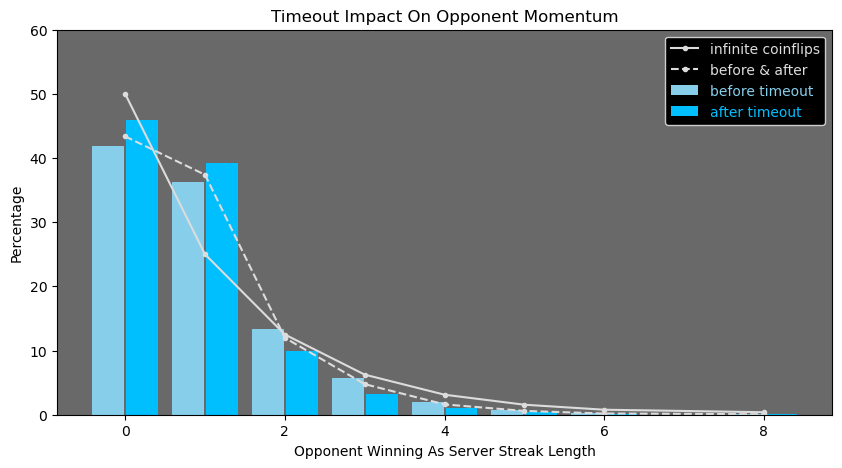

In [34]:
conn = psycopg2.connect(database="postgres",
                        host="pklmartdb.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="momentum101",
                        port="5432")
conn.autocommit = True
mainstats()

SKILL: Pro:

Counting streak lengths pre/post timeout for skill level: PRO

# skill games:246

# games with timeouts: 144

game_id: 1


game_id: 2


game_id: 3


game_id: 4


game_id: 5


game_id: 6


game_id: 7


game_id: 8


game_id: 9


game_id: 10


game_id: 11


game_id: 12


game_id: 13


game_id: 14


game_id: 15


game_id: 16


game_id: 17


game_id: 18


game_id: 19


game_id: 20


game_id: 21


game_id: 22


game_id: 23


game_id: 24


game_id: 26


game_id: 54


game_id: 27


game_id: 28


game_id: 30


game_id: 29


game_id: 31


game_id: 32


game_id: 33


game_id: 34


game_id: 35


game_id: 36


game_id: 37


game_id: 38


game_id: 39


game_id: 40


game_id: 41


game_id: 42


game_id: 43


game_id: 47


game_id: 48


game_id: 49


game_id: 50


game_id: 51


game_id: 52


game_id: 53


game_id: 55


game_id: 56


game_id: 57


game_id: 58


game_id: 59


game_id: 60


game_id: 61


game_id: 62


game_id: 63


game_id: 64


game_id: 65


game_id: 68


game_id: 66


game

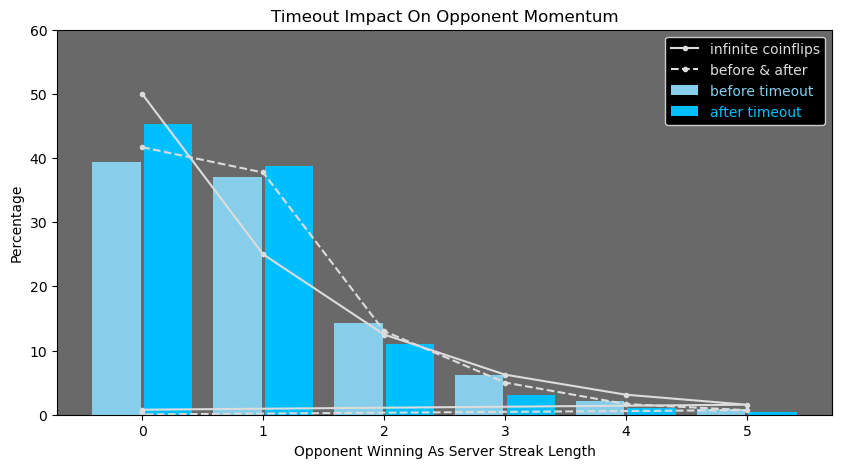

In [35]:
mainstats('Pro')

SKILL: 4.5:

Counting streak lengths pre/post timeout for skill level: 4.5

# skill games:86

# games with timeouts: 24

game_id: 1


game_id: 2


game_id: 3


game_id: 4


game_id: 5


game_id: 6


game_id: 7


game_id: 8


game_id: 9


game_id: 10


game_id: 11


game_id: 12


game_id: 13


game_id: 14


game_id: 15


game_id: 16


game_id: 17


game_id: 18


game_id: 19


game_id: 20


game_id: 21


game_id: 22


game_id: 23


game_id: 24


game_id: 26


game_id: 54


game_id: 27


game_id: 28


game_id: 30


game_id: 29


game_id: 31


game_id: 32


game_id: 33


game_id: 34


game_id: 35


game_id: 36


game_id: 37


game_id: 38


game_id: 39


game_id: 40


game_id: 41


game_id: 42


game_id: 43


game_id: 47


game_id: 48


game_id: 49


game_id: 50


game_id: 51


game_id: 52


game_id: 53


game_id: 55


game_id: 56


game_id: 57


game_id: 58


game_id: 59


game_id: 60


game_id: 61


game_id: 62


game_id: 63


game_id: 64


game_id: 65


game_id: 68


game_id: 66


game_i

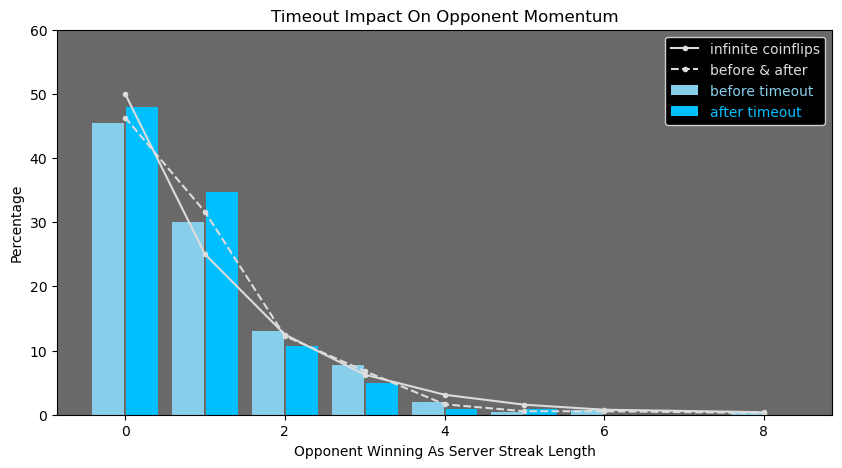

In [41]:
mainstats('4.5')

SKILL: Amateur:

Counting streak lengths pre/post timeout for skill level: AMATEUR

# skill games:468

# games with timeouts: 100

game_id: 1


game_id: 2


game_id: 3


game_id: 4


game_id: 5


game_id: 6


game_id: 7


game_id: 8


game_id: 9


game_id: 10


game_id: 11


game_id: 12


game_id: 13


game_id: 14


game_id: 15


game_id: 16


game_id: 17


game_id: 18


game_id: 19


game_id: 20


game_id: 21


game_id: 22


game_id: 23


game_id: 24


game_id: 26


game_id: 54


game_id: 27


game_id: 28


game_id: 30


game_id: 29


game_id: 31


game_id: 32


game_id: 33


game_id: 34


game_id: 35


game_id: 36


game_id: 37


game_id: 38


game_id: 39


game_id: 40


game_id: 41


game_id: 42


game_id: 43


game_id: 47


game_id: 48


game_id: 49


game_id: 50


game_id: 51


game_id: 52


game_id: 53


game_id: 55


game_id: 56


game_id: 57


game_id: 58


game_id: 59


game_id: 60


game_id: 61


game_id: 62


game_id: 63


game_id: 64


game_id: 65


game_id: 68


game_id: 6

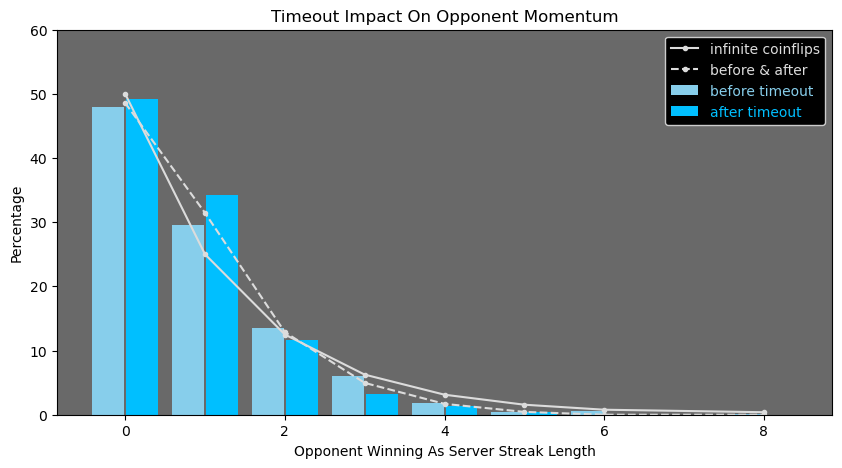

In [32]:
mainstats('Amateur')